In [ ]:
Benjamin Gavrilov
Predicting Titanic Surivorship

## Importing the Necessary Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

## Basic Data Analytics

In [3]:
pd.set_option('display.max_columns', None)
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


**train_df has 891 Instances with 11 features and the target variable of 'survived'**

In [5]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


**Some basic, descriptive statistics of the data set. We can see that approx 38% survived, the average age was approximately 29.
In addition, we see that there are 714 instances of Age, when we are supposed to have 891, hence we are missing data.**

In [6]:
print(train_df.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


**Below I have calculated how many missing values are within each feature. We can see that Age and Cabin have the most missing with 177 and 687 respectively. Embarked is missing 2 values which is not too big of a concern and will be dealt with simply.**

In [8]:
missing = train_df.isnull().sum().sort_values(ascending=True)
print(missing)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age            177
Cabin          687
dtype: int64


## Data Preprocessing

**From my preliminary hypothesis, I believe the following features do not have a material impact on survivorship:
PassengerID, Ticket, Name, Cabin. The Cabin feature is fairly interesting because I believe it can be useful, but with 687 missing values, it will not provide us the value we need in our model, hence, it will be cut from the dataset.**

In [9]:
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
print(train_df.head())
print(train_df.info())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
None


**Above, we see the new info table of the dataset. We now need to take the data and apply some preprocessing techniques.**

#### Converting categorical data into numerical ones
##### Converting Sex from male, female to Male:0 and Female:1

In [10]:
data = [train_df, test_df]
genders = {'male': 0, 'female': 1}
for i in data:
    i['Sex'] = i['Sex'].map(genders)

##### Converting Embarked Data
**The Embarked feature has 3 ports: S, C, Q. The counts below show 644 on Ports S, 168 on Port C, and 77 on Port Q. As noted in the 'missing' table, we are missing 2 values in Embarked. We will convert the strings to numerical values.**

In [11]:
embark_count = train_df['Embarked'].value_counts()
print(embark_count)

ports = {'S': 0, 'C': 1, 'Q': 2}
data = [train_df, test_df]
for i in data:
    i['Embarked'] = i['Embarked'].map(ports)
print(train_df.head())

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    0  22.0      1      0   7.2500       0.0
1         1       1    1  38.0      1      0  71.2833       1.0
2         1       3    1  26.0      0      0   7.9250       0.0
3         1       1    1  35.0      1      0  53.1000       0.0
4         0       3    0  35.0      0      0   8.0500       0.0


**Now, since all the values in Embarked have been converted to numerical ones, we will fill in the missing values. The most common value is S or, in our new case, '0.0'. Therefore, we will simply insert two instances of 0.0 into the missing set.**

In [12]:
data = [train_df, test_df]
for i in data:
    i['Embarked'] = i['Embarked'].fillna(0.0)

##### Filling in Age missing Values through Mean Imputation

In [13]:
mean_age = train_df['Age'].mean()
train_df['Age'].fillna(mean_age, inplace=True)
test_df['Age'].fillna(mean_age, inplace=True)

##### Converting Fare data type from float to int

In [14]:
data = [train_df, test_df]
for i in data:
    i['Fare'] = i['Fare'].fillna(0)
    i['Fare'] = i['Fare'].astype(int)

#### Correlation Matrix
**Through this correlation matrix, we can see a potential area to analyze further: Survivorship x Age and
Survivorship x Fare. Age appeared to have the highest correlation of 0.54 and Fare of 0.26.
These two relationships provide us with a foundation to dive deeper.**

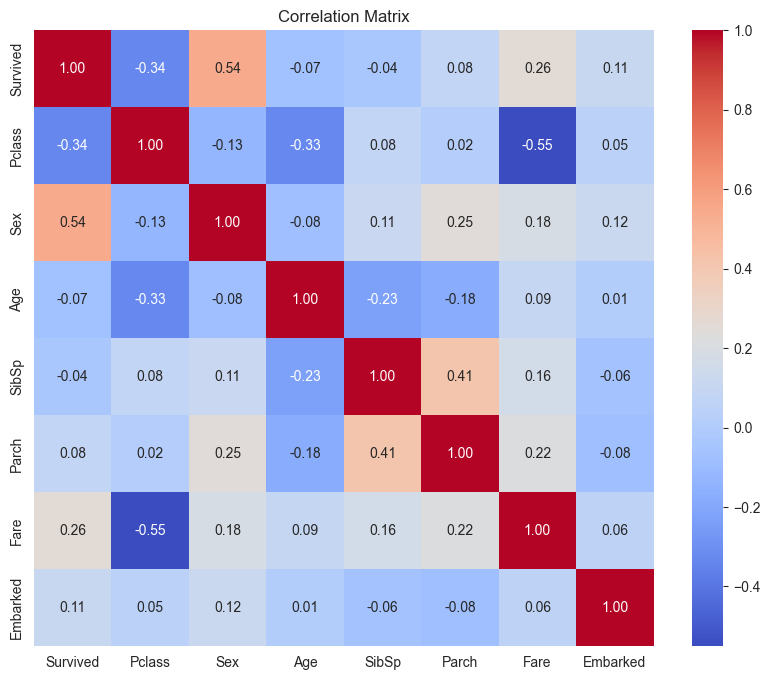

In [15]:
corr_matrix = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Machine Learning Models
**I will implement the following three models - Decision Tree, Logistic Regression, and Random Forest.**

In [16]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.copy()

#### Decision Tree

In [17]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)

**Below is the visualization of the decision tree:**

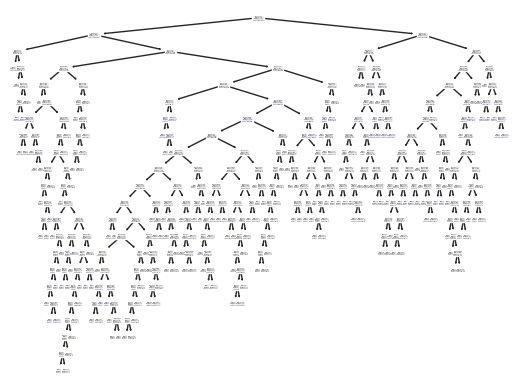

In [20]:
tree.plot_tree(decision_tree)
plt.show()

**Below is the text output for the decision tree as well:**

In [21]:
text_rep = tree.export_text(decision_tree)
print(text_rep)

|--- feature_1 <= 0.50
|   |--- feature_2 <= 6.50
|   |   |--- feature_3 <= 2.50
|   |   |   |--- class: 1
|   |   |--- feature_3 >  2.50
|   |   |   |--- feature_4 <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- feature_4 >  1.50
|   |   |   |   |--- feature_2 <= 3.50
|   |   |   |   |   |--- feature_3 <= 4.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_3 >  4.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_2 >  3.50
|   |   |   |   |   |--- class: 0
|   |--- feature_2 >  6.50
|   |   |--- feature_0 <= 1.50
|   |   |   |--- feature_2 <= 53.00
|   |   |   |   |--- feature_5 <= 25.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  25.50
|   |   |   |   |   |--- feature_5 <= 26.50
|   |   |   |   |   |   |--- feature_2 <= 31.85
|   |   |   |   |   |   |   |--- feature_2 <= 28.85
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_2 >  28.85
|   |   |   |   |   |   |   |   |--- c

#### Logistic Regression

In [22]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
log_pred = logreg.predict(X_test)

c:\users\forest\pycharmprojects\bankruptcy\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Random Forest

In [23]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

## Accuracy Metrics of Models
**We can see the Decision Tree and the Random Forest Model rank the highest with 96.52% accuracy while the Logistic Regression Model scores lower with 80.25. However, I believe the Log Reg model scored lower due to the model capping out at a certain level of iterations as noted in the error message above.**

In [24]:
accuracy_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
accuracy_regression = round(logreg.score(X_train, Y_train) * 100, 2)
accuracy_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(f'Decision Tree Score: ', accuracy_decision_tree)
print(f'Logistic Regression Score: ', accuracy_regression)
print(f'Random Forest Score: ', accuracy_random_forest)

Decision Tree Score:  96.52
Logistic Regression Score:  80.25
Random Forest Score:  96.52


## Confusion Matrices
**I created confusion matrices to visualize the amount of correct and incorrect predictions each model outputted.**

In [25]:
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
predictions2 = cross_val_predict(logreg, X_train, Y_train, cv=3)
predictions3 = cross_val_predict(decision_tree, X_train, Y_train, cv=3)


confusion_matrix_dt = confusion_matrix(Y_train, predictions3)
confusion_matrix_lr = confusion_matrix(Y_train, predictions2)
confusion_matrix_rf = confusion_matrix(Y_train, predictions)

c:\users\forest\pycharmprojects\bankruptcy\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\forest\pycharmprojects\bankruptcy\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [26]:
def plot_confusion_matrix(confusion_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

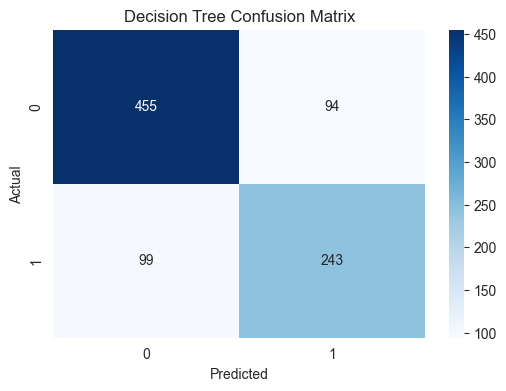

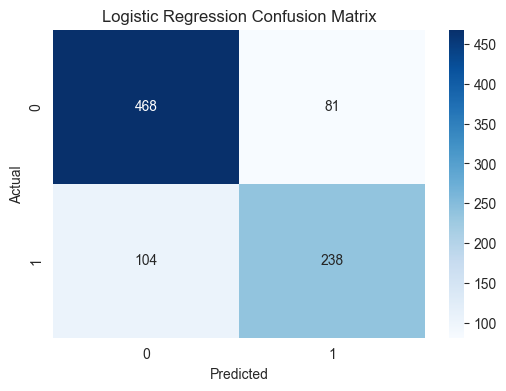

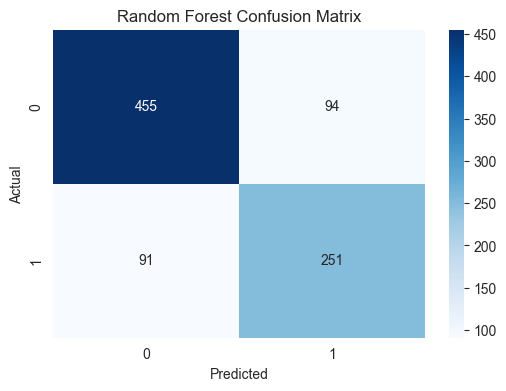

In [27]:
plot_confusion_matrix(confusion_matrix_dt, 'Decision Tree Confusion Matrix')
plot_confusion_matrix(confusion_matrix_lr, 'Logistic Regression Confusion Matrix')
plot_confusion_matrix(confusion_matrix_rf, 'Random Forest Confusion Matrix')

**Above, one can interpret the confusion matrices as such. For example, looking at the Random Forest matrix, in the top left quadrant with the value of 455, this represents that our model correctly predicted that 455 did not survive. The quadrant below, with the value of 91, represents that our model predicted that 91 did not survive when they actually did survive. Top right quadrant of 94 indicates our model predicted 91 survived when in fact they did not. And the quadrant below with value of 251, indicates that our model predicted 251 survived when they in fact did survive.**